# WZE-UAV Image Classification using Deep Learning

In [1]:
import os
import gc
import glob
import numpy as np
from pathlib import Path
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold

In [2]:
import torch
import torchvision.transforms as T
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from mlxtend.plotting import plot_confusion_matrix

In [3]:
import wze_uav.data_loader as data_loader
import wze_uav.models as models
from wze_uav.engine import *
from wze_uav.utils2 import *
#from wze_uav.log_writer import create_writer
from wze_uav.datasplit import *
from wze_uav.visualization import *
from efficientnet import model_effnet #for custom effnet with n_channels input


#### Get PyTorch version

In [4]:
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 1.13.1+cu116
torchvision version: 0.14.1+cu116


#### Preparing device agnostic code 

In [5]:
# ensure device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# get index of currently selected device
print(f"Index of current divice: {torch.cuda.current_device()}")
# get number of GPUs available
print(f"Number of GPUs available: {torch.cuda.device_count()}")
# get the name of the device
print(f"GPU Model: {torch.cuda.get_device_name(0)}")

cuda
Index of current divice: 0
Number of GPUs available: 1
GPU Model: Quadro RTX 8000


#### Ensure reproducibility 

In [6]:
# for more information, see also: https://pytorch.org/docs/stable/notes/randomness.html

# Set seeds
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)
    # seed for numpy
    np.random.seed(seed)

set_seeds(42) 

# Set to true -> might speed up the process but should be set to False if reproducible results are desired
torch.backends.cudnn.benchmark = False


In [7]:
import torch
import os
import findatree_roi.io as io
import findatree_roi.exporter as exporter
import numpy as np
from torch.utils.data import Dataset
from typing import Dict, List, Tuple
from torch.utils.data import WeightedRandomSampler
from tqdm.auto import tqdm
from collections import defaultdict
import hashlib

def hdf5_to_img_label(path_list, hashID_dict:dict, load_sets=None):
    count = 0
    for fn in tqdm(path_list, desc="Processing hdf5 datasets"):
        # load hdf5 data from path
        rois, params_rois, data, params_data = exporter.load_rois_from_hdf5_v2(fn,
                                                                               load_sets=load_sets) 
        # fetch images
        images = rois["images_masked"] # assigns all crown arrays from the different hdf5 files to dictionary
        images = images.transpose(3,0,1,2) # array transpose shape from (H, W, C, n) to (n, H, W, C)
        
        # fetch terrestrial features 
        crowns_human = data['crowns_human'] #get crown info with all terrestrial features
        labels = crowns_human['features']['terrestrial']['nbv'] # get needle or leaf loss
        species = crowns_human['features']['terrestrial']['ba'] # get tree species
        kkl = crowns_human['features']['terrestrial']['kkl']
        bk = crowns_human['features']['terrestrial']['bk']
        labels = labels.copy() # copy to avoid memory error
        species = species.copy()
        kkl = kkl.copy()
        bk = bk.copy()
        labels = labels.reshape(len(labels),1) # reshape from (samples,) to (samples,1)
        species = species.reshape(len(species),1)
        kkl = kkl.reshape(len(kkl),1)
        bk = bk.reshape(len(bk),1)
        if count >= 1:
            image_set = np.concatenate((image_set, images), axis=0)  # concatenate all crown arrays to one image_set
            label_set = np.concatenate((label_set, labels), axis=0)  
            species_set = np.concatenate((species_set, species), axis=0)
            kkl_set = np.concatenate((kkl_set, kkl), axis=0)
            bk_set = np.concatenate((bk_set, bk), axis=0)
            count = count + 1
        else:
            image_set = images
            label_set = labels # define label_set with the first sets of labels
            species_set = species
            kkl_set = kkl
            bk_set = bk
            count = count + 1
    
    # get hash_id
    hash_id = []        
    for key, value in hashID_dict.items():
        hash_id.append(value)
        
    hash_id = np.array(hash_id)  
    #hash_id = hash_id.reshape((-1, 1)) # from (samples,) to (samples,1)
    
    # filter data depending on terrestrial features
    np_filter = []
    for i in range(0, len(bk_set)):
        if label_set[i] >= 99 and kkl_set[i] <= 3 and (bk_set[i] <= 1 or (bk_set[i] >= 320 and bk_set[i] <= 340)):
            np_filter.append(True)
        else:
            np_filter.append(False)
        
    image_set = image_set[np_filter]
    label_set = label_set[np_filter]
    species_set = species_set[np_filter]
    kkl_set = kkl_set[np_filter]
    bk_set = bk_set[np_filter]
    hash_id = hash_id[np_filter]
        
    del rois, params_rois, data, params_data, crowns_human
    return image_set, label_set, species_set, kkl_set, bk_set, hash_id

#### Define file directory

In [8]:
#####################################################################################
# 3 channel input (r-g-b)
data_path = r"D:\Drohnendaten\10_WZE-UAV\Auswertung_findatree\Datasplit\ROI\rgb"

# 4 channel input (r-g-b-nir)
#data_path = r"D:\Drohnendaten\10_WZE-UAV\Auswertung_findatree\Datasplit\ROI\rgb-nir"

# 5 channel input (r-g-b-re-nir)
#data_path = r"D:\Drohnendaten\10_WZE-UAV\Auswertung_findatree\Datasplit\ROI\rgb-re-nir"

# 6 channel input (r-g-b-re-nir)
#data_path = r"D:\Drohnendaten\10_WZE-UAV\Auswertung_findatree\Datasplit\ROI\rgb-re-nir-chm"

#####################################################################################

#### Get all file paths, years and plotIDs

In [9]:
fn_list = os.listdir(data_path)
path_list = []
#year_list = []
#plotID_list = []
# Iterate over all datafiles
for year in fn_list:
    year_dir = f'{data_path}\\{year}'
    for filename in os.listdir(year_dir):
        path = f'{year_dir}\\{filename}'
        #plotID = path.rsplit('_',1)[0].rsplit('r',1)[1]
        path_list.append(path)
        #year_list.append(year)
        #plotID_list.append(plotID)

#### Get unique plotIDs and years per available trees

In [10]:
hashID_dict = data_loader.get_unique_treeID(path_list)

Creating unique tree IDs...:   0%|          | 0/647 [00:00<?, ?it/s]

#### Import all imagery, labels and other features from hdf5 files

In [11]:
image_set, label_set, species_set, kkl_set, bk_set, hash_id = data_loader.hdf5_to_img_label(path_list,
                                                                                               hashID_dict,
                                                                                               load_sets=["images_masked"])

Processing hdf5 datasets:   0%|          | 0/647 [00:00<?, ?it/s]

#### Convert nbv to classes

In [12]:
label_set = nbv_to_sst_5classes(label_set)

In [13]:
# train transform with augmentation. 
transform = transforms.Compose([transforms.ToTensor(),
                                      #transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      #                     std=[0.229, 0.224, 0.225]),
                                      transforms.ColorJitter(brightness=(10,10)),
                                      #transforms.RandomHorizontalFlip(p=0.5),
                                      #transforms.RandomVerticalFlip(p=0.5),
                                      #transforms.RandomRotation(degrees=[0,360])
                                      #transforms.Resize(224)
                                      ])


# class names need to fit the customDataset class used e.g. 3 classes -> use CustomDataset3Classes
class_names = ['healthy', 'slightly_stressed', 'moderately_stressed', 'highly_stressed', 'dead']
#class_names = ['dead', 'dead']
#class_names = ['healthy', 'moderately_stressed', 'highly_stressed', 'dead']
#class_names = ['Picea abies healthy', 'Picea abies stressed', 'Pinus sylvestris healthy', 'Pinus sylvestris stressed', 
#               'Abies alba healthy', 'Abies alba stressed', 'Fagus sylvatica healthy', 'Fagus sylvatica stressed',
#               'Quercus robur/petraea healthy', 'Quercus robur/petraea stressed', 'dead trees']

# choose custom dataset loader with 3 - 5 classes
dataset = data_loader.CustomDataset(data=image_set,
                                    labels=label_set,
                                    class_names=class_names,
                                    species = species_set,
                                    transform=transform)

In [14]:
#del image_set, label_set, species_set, kkl_set, bk_set, hash_id

In [18]:
label_set

array([2, 1, 1, ..., 0, 0, 0])

In [15]:
import random
import matplotlib.pyplot as plt
import copy

def display_filtered_imagesv4(dataset, label=None, species=None, n=10, display_shape=True, seed=None, export_path=None):
    # Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print("For display purposes, n shouldn't be larger than 10. Setting n to 10 and removing shape display.")

    # Set random seed
    if seed is not None:
        random.seed(seed)

    # Make a copy of the dataset
    shuffled_dataset = copy.deepcopy(dataset)

    # Shuffle and select random samples from filtered dataset
    random.shuffle(shuffled_dataset)
    random_samples = shuffled_dataset[:n]

    # Setup plot
    plt.figure(figsize=(30, 20))

    # Loop through samples and display random samples
    for i, (targ_image, targ_label, targ_species) in enumerate(random_samples):
        # Adjust image tensor shape for plotting: [color_channels, height, width] -> [height, width, color_channels]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        #if display_shape:
        #    title = f"Label: {targ_label} | Species: {targ_species}\n ID: {}\n"
        #    #title = f"Label: {targ_label} | Species: {targ_species}\nShape: {targ_image_adjust.shape}"
        #else:
        #    title = f"Label: {targ_label} | Species: {targ_species}"
        #plt.title(title)

        # Export the image as PNG
        if export_path:
            image_filename = f"{species}_{label}_{seed}.png"
            export_filepath = f"{export_path}/{image_filename}"
            plt.savefig(export_filepath)

    # Show the plot
    plt.show()


In [71]:
#### Filter dataset by label and species
label = None
species = 5
filtered_dataset = [(image, image_label, dataset.species[i]) for i, (image, image_label) in enumerate(dataset) if
                        (label is None or image_label == label) and (species is None or dataset.species[i] == species)]

In [90]:
seed = 9
export_path = r"D:\Drohnendaten\10_WZE-UAV\Images_dataset"



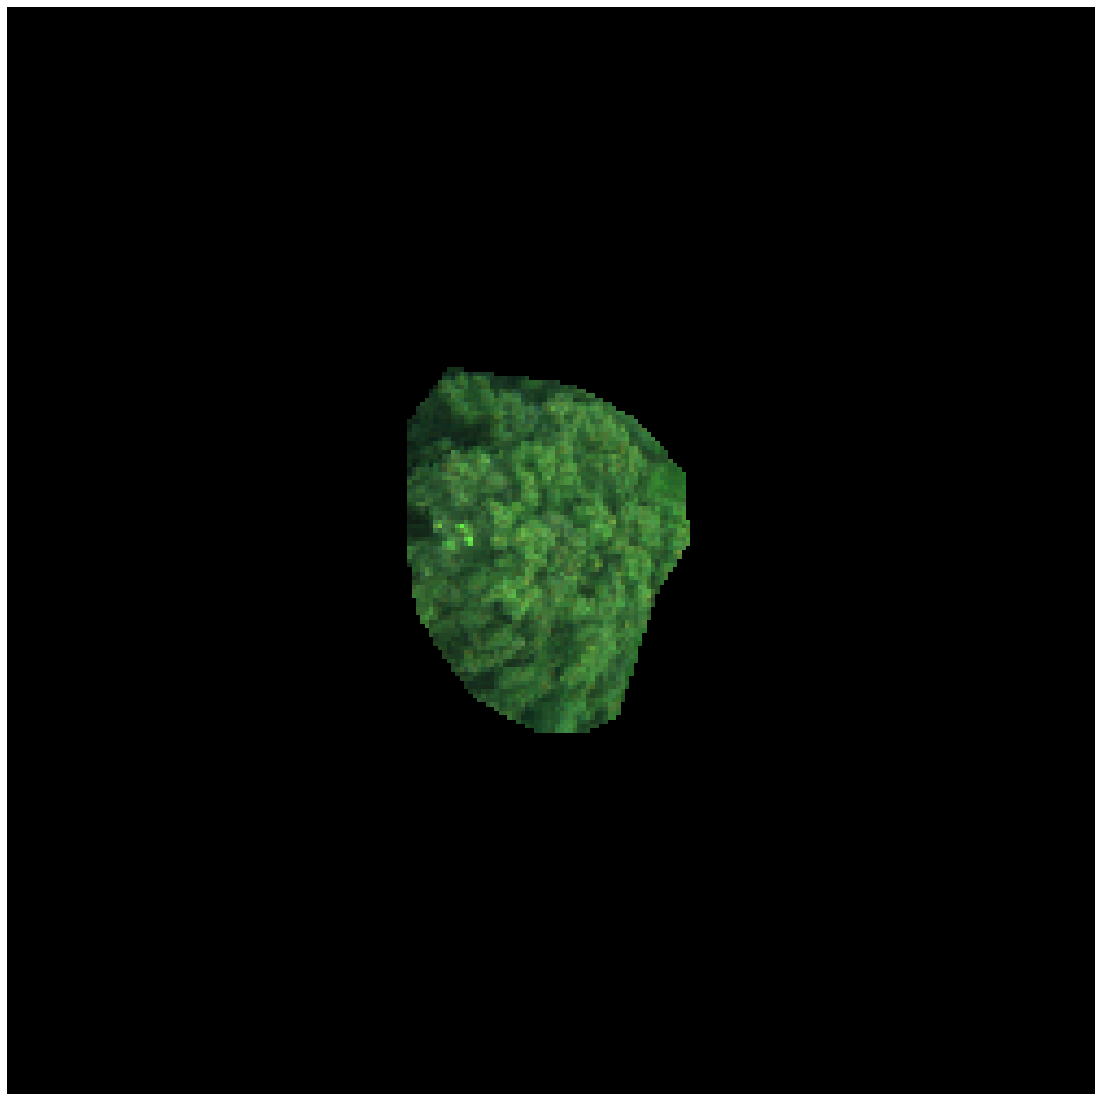

In [91]:
display_filtered_images(filtered_dataset,label=label, species=species, n=1, seed=seed, export_path=export_path)